<a href="https://colab.research.google.com/github/rohankrgupta/Lung-X-Ray-Classification-Deep-Learning/blob/master/CovidNet_ensemble_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib
import os
import random
import pandas as pd
import imageio

import cv2
import shutil

from scipy.stats.mstats import linregress
from tensorflow.keras.preprocessing.image import img_to_array
from random import uniform
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.layers import BatchNormalization
from keras.utils import normalize
import pickle

#dependencies
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

matplotlib.use('Agg')

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Database.zip to Database.zip
User uploaded file "Database.zip" with length 349581599 bytes


Saving test.zip to test.zip
User uploaded file "test.zip" with length 59913358 bytes


In [3]:
import os
import zipfile

local_zip = '/content/Database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

base_dir = '/content/Database'

In [4]:
# Model
class CovidNet:
  @staticmethod
  def build_model1(inputs):
    # Base Model
    base_model1 = EfficientNetB0(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False,
    drop_connect_rate=0.3,
    #pooling = max,
    input_tensor = inputs
    )
    # Set train to false
    base_model1.trainable = True
    
    #Get the last Layer
    last_layer1 = base_model1.get_layer('block7a_se_squeeze')
    last_output1 = last_layer1.output
    
    # Flatten the output layer to 1 dimension
    x1 = layers.Flatten()(last_output1)
    x1 = layers.Dense(1024, activation='relu', name = 'denselayer1')(x1)
    x1 = layers.Dense(3, activation='softmax', name = "model1_output")(x1)
    
    return x1

  @staticmethod
  def build_model2(inputs):
    # Base Model
    base_model2 = EfficientNetB0(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False,
    drop_connect_rate=0.3,
    #pooling = max,
    input_tensor = inputs
    )

    # Set train to false
    base_model2.trainable = True
    
    for layer in base_model2.layers:
      layer._name = 'new' + str(layer._name)

    #Get the last Layer
    last_layer2 = base_model2.get_layer('newblock7a_se_squeeze')
    last_output2 = last_layer2.output
    
    # Flatten the output layer to 1 dimension
    x2 = layers.Flatten()(last_output2)
    x2 = layers.Dense(1024, activation='relu', name = 'denselayer2')(x2)
    x2 = layers.Dense(3, activation='softmax', name = "model2_output")(x2)
   
    return x2  

  @staticmethod
  def build():
    
    inputShape = (224, 224, 3)
    inputs = tf.keras.Input(shape = inputShape)
    
    model1 = CovidNet.build_model1(inputs)
    model2 = CovidNet.build_model2(inputs)

    model = Model(
        inputs = inputs,
        outputs = (model1+model2)/2,
        name='covidnet'
    )

    #return the constructed arhitecture
    return model
    

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(
    horizontal_flip=True)

testAug = ImageDataGenerator()

mean = np.array([0.485, 0.456, 0.406], dtype= "float32")
std = np.array([0.229, 0.224, 0.225], dtype= "float32")

trainAug.mean = mean
testAug.mean = mean
trainAug.std = std
testAug.std = std

train_generator = trainAug.flow_from_directory(
    '/content/Database/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

validation_generator = testAug.flow_from_directory(
    '/content/Database/test',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

Found 3526 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [9]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [12]:
EPOCHS = 30
INIT_LR = 3e-5
BS = 20

model = CovidNet.build()
opt = keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
print("[INFO] training w/ generator...")

H = model.fit(
              train_generator,
              epochs= 30,
              validation_data=validation_generator, callbacks=[callback])

[INFO] training w/ generator...
Epoch 1/30
177/177 [==============================] - 89s 425ms/step - loss: 0.6101 - accuracy: 0.8281 - val_loss: 0.4729 - val_accuracy: 0.7528
Epoch 2/30
177/177 [==============================] - 73s 412ms/step - loss: 0.1415 - accuracy: 0.9521 - val_loss: 0.1552 - val_accuracy: 0.9444
Epoch 3/30
177/177 [==============================] - 73s 411ms/step - loss: 0.0810 - accuracy: 0.9779 - val_loss: 0.1425 - val_accuracy: 0.9389
Epoch 4/30
177/177 [==============================] - 73s 411ms/step - loss: 0.0551 - accuracy: 0.9819 - val_loss: 0.0977 - val_accuracy: 0.9694
Epoch 5/30
177/177 [==============================] - 73s 412ms/step - loss: 0.0479 - accuracy: 0.9839 - val_loss: 0.0536 - val_accuracy: 0.9778
Epoch 6/30
177/177 [==============================] - 73s 413ms/step - loss: 0.0374 - accuracy: 0.9896 - val_loss: 0.0485 - val_accuracy: 0.9806
Epoch 7/30
177/177 [==============================] - 73s 412ms/step - loss: 0.0577 - accuracy: 0.

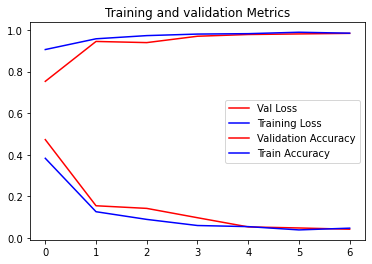

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
R22 = H.history['loss']
R21 = H.history['val_loss']
val_R21 = H.history['val_accuracy']
val_R22 = H.history['accuracy']

epochs = range(len(R22))

plt.plot(epochs, R21, 'r', label='Val Loss')
plt.plot(epochs, R22, 'b', label = 'Training Loss')
plt.plot(epochs, val_R21, 'r', label='Validation Accuracy')
plt.plot(epochs, val_R22, 'b', label='Train Accuracy')
plt.title('Training and validation Metrics')
plt.legend(loc=0)
plt.figure()


plt.show()

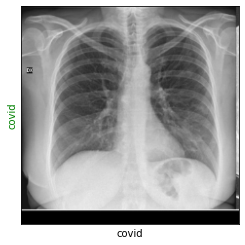

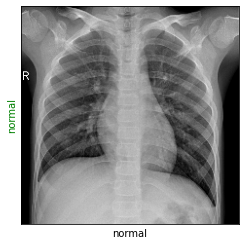

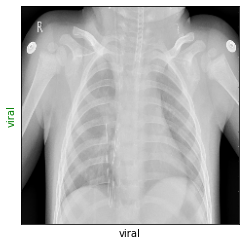

In [91]:
from keras.preprocessing import image 

test_dir = '/content/Database/test/'

class_names = ['covid', 'normal', 'viral']

for labels in class_names:
  images = [x for x in os.listdir(os.path.join(test_dir, labels))]
  #print(images)
  selected_image = random.sample(images, 1)
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 1, 1, xticks=[], yticks=[])
  for img in selected_image:
    imag = cv2.imread(test_dir + labels + '/' + img)
    imag = cv2.resize(imag, (224, 224))
    x = image.img_to_array(imag)
    preds = model.predict(np.expand_dims(x, axis=0))
    preds = np.argmax(preds, axis=1)
    plt.imshow(imag)
    col = 'green'
    if(class_names[preds[0]] != labels):
      col = 'red'
    plt.xlabel(f'{labels}')
    plt.ylabel(f'{class_names[preds[0]]}', color=col)


plt.show()